In [1]:
import os
import sys
from getpass import getpass
import pathlib
import json
import pandas as pd
import numpy as np
import csv
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

LOCAL_PATH = "/tmp/patent-analysis"
DATA_PATH = os.path.join(LOCAL_PATH, 'dataset')
PERMANENT_STORAGE = "/patent-analysis/dataset"

sys.path.append(LOCAL_PATH)

import dask.dataframe as dask
from dask.distributed import Client

from utils.stats import print_ddf_stats

In [2]:
!python data/uspto_bulk_download.py 


Using TensorFlow backend.
Preparing dataset patent
Preparing dataset uspatentcitation
Preparing dataset location
Preparing dataset assignee
Preparing dataset patent_assignee
Preparing dataset patent_inventor
Preparing dataset cpc_current
sending incremental file list

sent 11.55K bytes  received 20 bytes  23.13K bytes/sec
total size is 10.28G  speedup is 889,031.42


In [3]:
# !python data/uspto_bulk_download.py \
#         --local_storage=$DATA_PATH \
#         --permanent_storage=$PERMANENT_STORAGE

In [4]:
ncpus = len(os.sched_getaffinity(0))
print("Number of CPUs available:", ncpus)
client = Client(n_workers=32, threads_per_worker=2, memory_limit='6GB', dashboard_address='6006')
client

Number of CPUs available: 64


Client Scheduler: tcp://127.0.0.1:41435 Dashboard: http://127.0.0.1:6006/status,Cluster Workers: 32 Cores: 64 Memory: 192.00 GB


In [5]:
ddf_patent = dask.read_parquet('data/patents-view/patent.parquet')
# print_ddf_stats(ddf_patent)

In [6]:
ddf_patent_inventor = dask.read_parquet('data/patents-view/patent_inventor.parquet')
# print_ddf_stats(ddf_patent_inventor)

In [7]:
ddf_patent_assignee = dask.read_parquet('data/patents-view/patent_assignee.parquet')
# print_ddf_stats(ddf_patent_assignee)

In [8]:
ddf_location = dask.read_parquet('data/patents-view/location.parquet')
# print_ddf_stats(ddf_location)

In [9]:
ddf_cpc = dask.read_parquet('data/patents-view/cpc_current.parquet')
ddf_cpc4 = ddf_cpc.map_partitions(lambda x: x[['group_id']].reset_index().drop_duplicates().set_index('patent_id')).persist()
ddf_cpc_full = ddf_cpc.map_partitions(lambda x: x[['subgroup_id']].reset_index().drop_duplicates().set_index('patent_id')).persist()
# print_ddf_stats(ddf_cpc)

In [10]:
ddf = ddf_patent.merge(ddf_patent_inventor, how='left', left_index=True, right_index=True)
ddf = ddf.merge(ddf_patent_assignee, how='left', left_index=True, right_index=True)
ddf = ddf.merge(ddf_cpc4, how='left', left_index=True, right_index=True)


ddf = ddf.merge(ddf_location.rename(columns=dict(zip(ddf_location.columns, 
                                                     [c + '_inventor' for c in ddf_location.columns]))), 
                how='left', left_on='location_id_inventor', right_on='id')

ddf = ddf.merge(ddf_location.rename(columns=dict(zip(ddf_location.columns, 
                                                     [c + '_assignee' for c in ddf_location.columns]))), 
                how='left', left_on='location_id_assignee', right_on='id')


ddf = ddf.persist()
ddf

,type,number,country,date,title,kind,num_claims,inventor_id,location_id_inventor,assignee_id,location_id_assignee,group_id,city_inventor,state_inventor,country_inventor,latitude_inventor,longitude_inventor,county_inventor,city_assignee,state_assignee,country_assignee,latitude_assignee,longitude_assignee,county_assignee
npartitions=181,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,datetime64[ns],object,object,int16,object,object,object,object,object,object,object,object,float32,float32,object,object,object,object,float32,float32,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [11]:
ddf.head()

,type,number,country,date,title,kind,num_claims,inventor_id,location_id_inventor,assignee_id,...,country_inventor,latitude_inventor,longitude_inventor,county_inventor,city_assignee,state_assignee,country_assignee,latitude_assignee,longitude_assignee,county_assignee
0,utility,10000000,US,2018-06-19,Coherent LADAR using intra-pixel quadrature de...,B2,20,5073021-1,eaa3078f-0dfd-4ddc-8ea3-0057c827e497,org_G6Usf0czKGQH90EpLFrp,...,US,33.884701,-118.410004,Los Angeles,Waltham,MA,US,42.376400,-71.236099,Middlesex
1,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,10000001-2,f19948bb-f2cb-4897-a14f-d693b52b7676,org_UyldOHuAOBud968Ru46i,...,KR,37.321899,126.831001,None,Gyeonggi-do,None,KR,37.413799,127.517998,None
2,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,10000001-2,f19948bb-f2cb-4897-a14f-d693b52b7676,org_UyldOHuAOBud968Ru46i,...,KR,37.321899,126.831001,None,Gyeonggi-do,None,KR,37.413799,127.517998,None
3,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,7354823-3,44043cd3-222b-41d3-a94d-70949983475e,org_UyldOHuAOBud968Ru46i,...,KR,37.361698,126.934998,None,Gyeonggi-do,None,KR,37.413799,127.517998,None
4,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,7354823-3,44043cd3-222b-41d3-a94d-70949983475e,org_UyldOHuAOBud968Ru46i,...,KR,37.361698,126.934998,None,Gyeonggi-do,None,KR,37.413799,127.517998,None


In [12]:
ddf.columns

Index(['type', 'number', 'country', 'date', 'title', 'kind', 'num_claims',
       'inventor_id', 'location_id_inventor', 'assignee_id',
       'location_id_assignee', 'group_id', 'city_inventor', 'state_inventor',
       'country_inventor', 'latitude_inventor', 'longitude_inventor',
       'county_inventor', 'city_assignee', 'state_assignee',
       'country_assignee', 'latitude_assignee', 'longitude_assignee',
       'county_assignee'],
      dtype='object')

## Plot the pie-chart of the patent distribution per assignee

In [13]:
assignee_country_counts = ddf.map_partitions(lambda x: x.groupby('number')['country_assignee'].first()).compute()
assignee_country_counts = assignee_country_counts.value_counts()
assignee_country_counts

US    3406937
JP    1306690
DE     394387
KR     272520
TW     177625
       ...   
FJ          1
GC          1
BW          1
BF          1
SZ          1
Name: country_assignee, Length: 206, dtype: int64

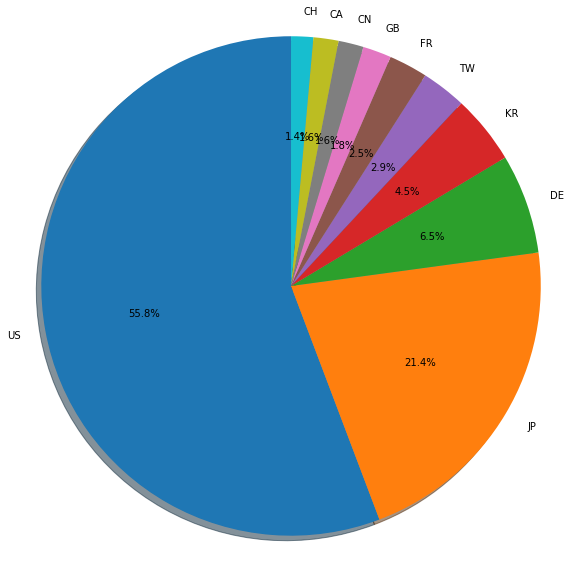

In [14]:
x = dict(100 * assignee_country_counts[:10] / assignee_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot the pie-chart of the patent distribution per inventor

In [15]:
inventor_country_counts = ddf.map_partitions(lambda x: x.groupby('number')['country_inventor'].first()).compute()
inventor_country_counts = inventor_country_counts.value_counts()
inventor_country_counts

US    3874231
JP    1319830
DE     446399
KR     275035
TW     222234
       ...   
GC          1
CV          1
TS          1
OK          1
CG          1
Name: country_inventor, Length: 244, dtype: int64

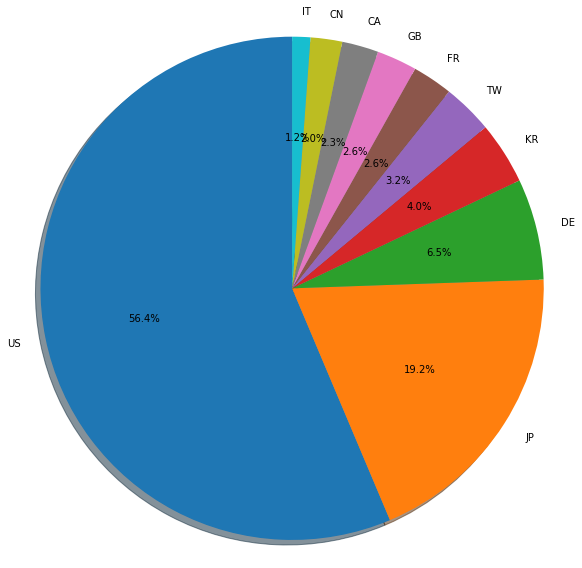

In [16]:
x = dict(100 * inventor_country_counts[:10] / inventor_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot distribution of patent types and kinds

In [17]:
patent_type = ddf.map_partitions(lambda x: x.groupby('number')['type'].first()).compute()
patent_type = patent_type.value_counts()
patent_type

utility                             6824356
design                               654231
plant                                 28219
reissue                               19386
statutory invention registration       2259
defensive publication                   509
TVPP                                      3
Name: type, dtype: int64

In [18]:
patent_kind= ddf.map_partitions(lambda x: x.groupby('number')['kind'].first()).compute()
patent_kind = patent_kind.value_counts()
patent_kind

B2    3781915
A     2391379
B1     651063
S1     444649
S      209582
P2      13549
E1      10694
E        8692
P        8282
P3       6388
H        1982
I4        509
H1        273
I5          3
H2          3
Name: kind, dtype: int64

## The distribution of the number of inventors per patent

          inventor_id
number               
10000000            1
10000001            2
10000002            4
10000003            3
10000004            2
...               ...
T998013             5
T998014             3
T999001             1
T999002             3
T999003             2

[7528963 rows x 1 columns]


<AxesSubplot:ylabel='Count'>

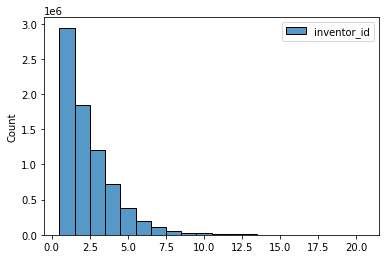

In [19]:
inventor_counts = ddf.map_partitions(lambda x: x.groupby(x.number).agg({'inventor_id': "nunique"})).compute()

print(inventor_counts)
sns.histplot(inventor_counts, bins=20, binrange=(1,20), discrete=True)

## The evolution of percentage of patents with a given number of inventor and a given number of geo-locations (cities) involved

In [20]:
geo_counts_time = ddf.map_partitions(lambda x: x.groupby(x.number).agg({'date': 'first', 
                                                                        'state_inventor': "nunique", 
                                                                        'city_inventor': "nunique", 
                                                                        'inventor_id': "nunique"})).compute()
geo_counts_time['year'] = geo_counts_time['date'].dt.year

In [21]:
inventor_counts_time = geo_counts_time.groupby('year')['inventor_id'].value_counts(normalize=True).to_frame()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'proportion'}).reset_index()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'inventor_count'})
inventor_counts_time = inventor_counts_time.groupby(['inventor_count', 'year']).agg({'proportion': 'first'})

city_counts_time = geo_counts_time.groupby('year')['city_inventor'].value_counts(normalize=True).to_frame()
city_counts_time = city_counts_time.rename(columns={'city_inventor': 'proportion'}).reset_index()
city_counts_time = city_counts_time.rename(columns={'city_inventor': 'city_count'})
city_counts_time = city_counts_time.groupby(['city_count', 'year']).agg({'proportion': 'first'})

inventor_counts_time.head()

proportion
inventor_count year            
0              1976    0.000479
               1977    0.000129
               1978    0.000170
               1979    0.000171
               1980    0.000362

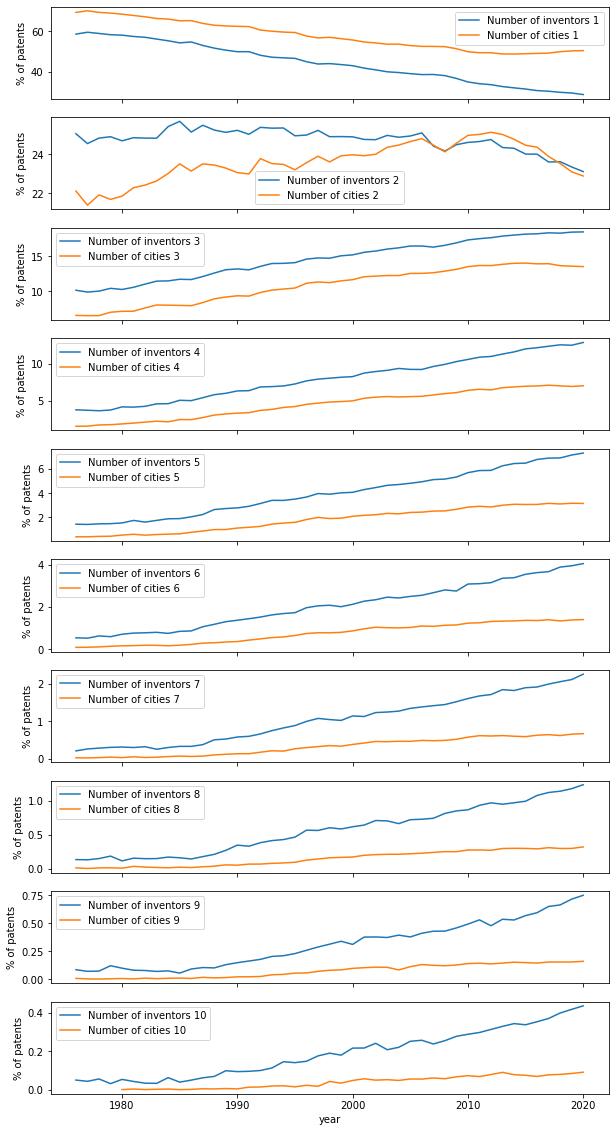

In [22]:
fig, axes = plt.subplots(10, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, count in enumerate(range(1, 11)):
    (100*inventor_counts_time.loc[count] ).plot(ax=axes[i])
    (100*city_counts_time.loc[count] ).plot(ax=axes[i])
    axes[i].legend([f"Number of inventors {i+1}", f"Number of cities {i+1}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")

## The distribution of the number of 4-character CPC codes per patent

          group_id
number            
10000000         1
10000001         2
10000002         6
10000003         4
10000004         3
...            ...
T998013          0
T998014          0
T999001          0
T999002          0
T999003          0

[7528963 rows x 1 columns]


<AxesSubplot:ylabel='Count'>

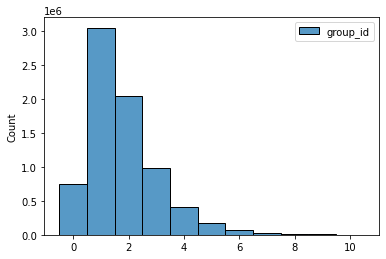

In [23]:
cpc4_code_counts = ddf.map_partitions(lambda x: x.groupby(x.number).agg({'group_id': "nunique"})).compute()

print(cpc4_code_counts)
sns.histplot(cpc4_code_counts, bins=11, binrange=(0,10), discrete=True)

## The evolution of percentage of patents with a given number of CPC4 codes

In [24]:
cpc4_code_counts_time = ddf.map_partitions(lambda x: x.groupby(x.number).agg({'date': 'first',
                                                                              'group_id': "nunique"})).compute()
cpc4_code_counts_time['year'] = cpc4_code_counts_time['date'].dt.year

In [25]:
cpc4_code_counts_time = cpc4_code_counts_time.groupby('year')['group_id'].value_counts(normalize=True).to_frame()
cpc4_code_counts_time = cpc4_code_counts_time.rename(columns={'group_id': 'proportion'}).reset_index()
cpc4_code_counts_time = cpc4_code_counts_time.rename(columns={'group_id': 'CPC4_count'})
cpc4_code_counts_time = cpc4_code_counts_time.groupby(['CPC4_count', 'year']).agg({'proportion': 'first'})
cpc4_code_counts_time

proportion
CPC4_count year            
0          1976    0.013039
           1977    0.068032
           1978    0.065027
           1979    0.070174
           1980    0.066785
...                     ...
30         2017    0.000009
           2018    0.000032
           2019    0.000038
           2020    0.000017
38         2020    0.000003

[850 rows x 1 columns]

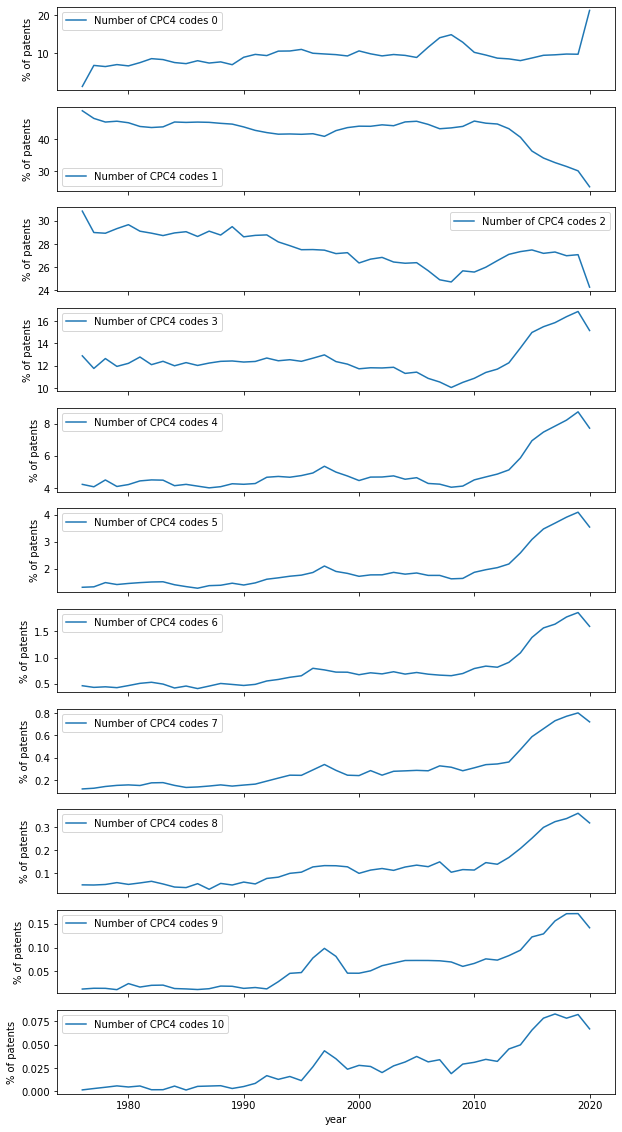

In [26]:
fig, axes = plt.subplots(11, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, count in enumerate(range(0, 11)):
    (100*cpc4_code_counts_time.loc[count] ).plot(ax=axes[i])
    axes[i].legend([f"Number of CPC4 codes {i}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")

## The distribution of patents across CPC4 codes

In [27]:
CPC4_code_counts = ddf.map_partitions(lambda x: x[['number', 'group_id']].drop_duplicates().\
                                     groupby('group_id').nunique()).compute()
CPC4_code_counts = CPC4_code_counts.groupby('group_id').sum().sort_values('number', ascending=False)


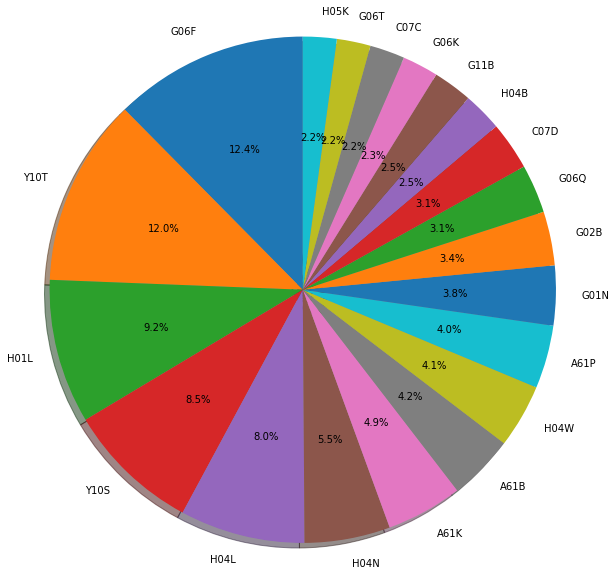

In [28]:
x = dict(100 * CPC4_code_counts['number'][:20] / CPC4_code_counts.values.sum())

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

<AxesSubplot:xlabel='group_id', ylabel='number'>

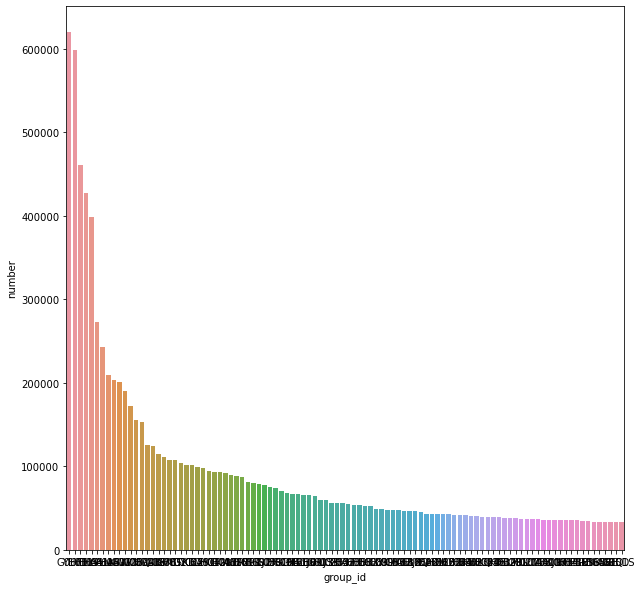

In [29]:
fig1, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='group_id', y='number', 
            data=CPC4_code_counts.reset_index()[:100])

## The distribution of years when a CPC4 group first appeared

<AxesSubplot:xlabel='index', ylabel='year'>

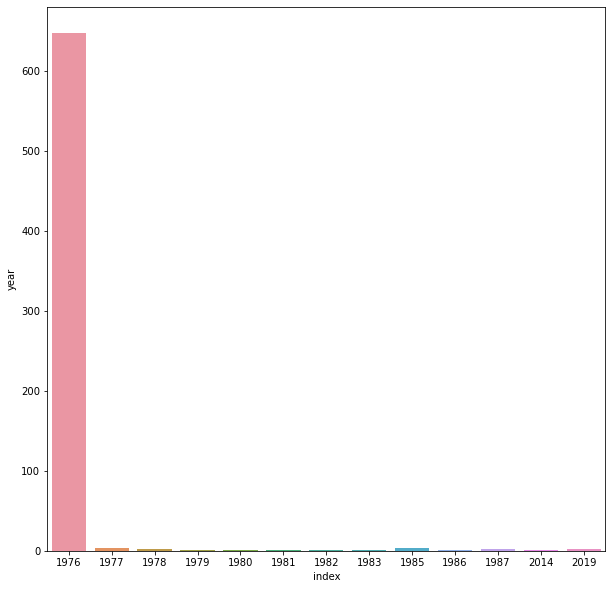

In [30]:
CPC4_code_appearance = ddf.map_partitions(lambda x: x[['group_id', 'date']].drop_duplicates().\
                                     groupby('group_id').min()).compute()
CPC4_code_appearance['year'] = CPC4_code_appearance['date'].dt.year

CPC4_code_appearance = CPC4_code_appearance.groupby('group_id').year.min()

fig1, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='index', y='year', 
            data=CPC4_code_appearance.value_counts().to_frame().reset_index())

## The appearance of new CPC4 codes over time

In [31]:
ddf_cpc['subgroup_id'].unique().compute()

0             G01S7/4914
1             G01S7/4917
2              G01S13/89
3             G01S17/894
4             G01S7/4863
               ...      
240748     C12Y102/01052
240749     C12Y401/02017
240750     G01N2333/7153
240751         A47F11/08
240752    C12N2760/18371
Name: subgroup_id, Length: 240753, dtype: object

In [32]:
CPCFULL_code_appearance = ddf_patent.merge(ddf_cpc_full, how='left', 
                                           left_index=True, right_index=True).map_partitions(lambda x: x[['subgroup_id', 'date']].drop_duplicates().\
                                           groupby('subgroup_id').min()).compute()
CPCFULL_code_appearance = CPCFULL_code_appearance.groupby('subgroup_id').min()
CPCFULL_code_appearance['date'] = CPCFULL_code_appearance['date'] +  pd.offsets.MonthBegin(0)
CPCFULL_code_appearance = CPCFULL_code_appearance.value_counts().to_frame().sort_index()

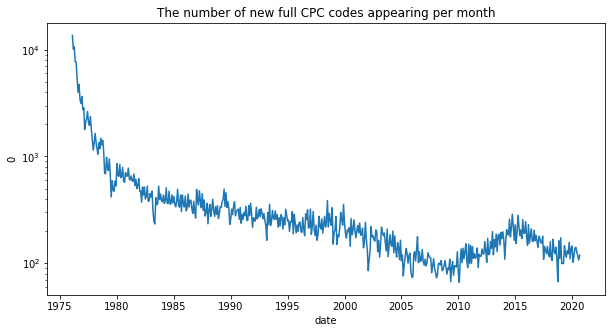

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=CPCFULL_code_appearance.reset_index(), x="date", y=0)
plt.yscale('log')
plt.title("The number of new full CPC codes appearing per month")
print()

## The appearance of new full CPC codes over time, grouped by largest CPC4 codes

In [34]:
CPCFULL_code_appearance_stacked = ddf_patent.merge(ddf_cpc_full, how='left', 
                                           left_index=True, right_index=True).map_partitions(lambda x: x[['subgroup_id', 'date']].drop_duplicates().\
                                           groupby('subgroup_id').min()).compute()
CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked.groupby('subgroup_id').min()
CPCFULL_code_appearance_stacked['year'] = CPCFULL_code_appearance_stacked['date'].dt.year

CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked.join(
    ddf_cpc.groupby('subgroup_id')['group_id'].first().compute())
CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked[['year', 'group_id']].value_counts()
CPCFULL_code_appearance_stacked


year  group_id
1976  Y10T        5163
      Y10S        2664
      B29C        1617
      C07C        1523
      B65D        1322
                  ... 
1985  B82B           1
2003  G04G           1
1985  C01C           1
      C01D           1
2020  Y10S           1
Length: 17843, dtype: int64

In [77]:
top_groups_all = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.groupby('group_id').sum().sort_values(ascending=False)[:10].index.values]


top_groups_1970 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1970 & year < 1980").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_1980 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1980 & year < 1990").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_1990 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1990 & year < 2000").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_2000 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 2000 & year < 2010").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_2010 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 2010 & year < 2020").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]

top_groups_all = []
top_groups_all = set(top_groups_all + top_groups_1970 + top_groups_1980 + top_groups_1990 + top_groups_2000 + top_groups_2010)
# only preserve top 20
top_groups_all = list(top_groups_all)[:20]
top_groups_all = ",".join(top_groups_all)
top_groups_all

CPCFULL_code_appearance_stacked_top = CPCFULL_code_appearance_stacked.to_frame().query(f"group_id in [{top_groups_all}]")
CPCFULL_code_appearance_stacked_top = CPCFULL_code_appearance_stacked_top.unstack()
CPCFULL_code_appearance_stacked_top

0                                                               \
group_id    Y10T    Y10S    B29C    C07C    B65D    H01L   B01D   G01N   B65H   
year                                                                            
1976      5163.0  2664.0  1617.0  1523.0  1322.0  1234.0  987.0  978.0  820.0   
1977      1316.0   686.0   399.0   299.0   318.0   396.0  251.0  271.0  240.0   
1978       703.0   366.0   241.0   181.0   205.0   205.0  169.0  170.0  112.0   
1979       329.0   197.0   124.0   107.0   136.0   160.0   98.0  123.0  101.0   
1980       355.0   189.0   109.0   124.0   141.0   159.0   86.0   96.0  100.0   
1981       282.0   163.0   105.0    86.0    71.0   122.0   98.0  123.0   61.0   
1982       170.0   103.0    87.0    69.0    49.0   115.0   57.0   79.0   70.0   
1983       134.0    95.0    93.0    68.0    49.0    95.0   47.0   74.0   54.0   
1984       138.0    96.0    70.0    66.0    52.0   107.0   43.0   90.0   75.0   
1985       126.0    96.0    62.0    65.0    54.0   136.0   35.0   89.0   59.0   
1986       116.0    90.0    57.0    47.0    33.0   111.0   38.0   76.0   63.0   
1987        92.0   100.0    64.0    47.0    32.0    93.0   29.0  109.0   52.0   
1988        71.0    65.0    55.0    36.0    49.0   119.0   38.0   91.0   42.0   
1989        63.0    94.0    62.0    95.0    53.0   156.0   34.0  108.0   50.0   
1990        38.0    96.0    48.0    81.0    34.0   127.0   17.0   83.0   38.0   
1991        50.0    58.0    45.0    73.0    32.0   137.0   29.0   93.0   52.0   
1992        40.0    64.0    56.0    82.0    31.0   157.0   18.0   72.0   30.0   
1993        27.0    46.0    58.0    37.0    30.0    96.0   35.0   69.0   42.0   
1994        21.0    57.0    48.0    22.0    20.0   112.0   13.0   56.0   57.0   
1995        22.0    32.0    49.0    24.0    33.0    77.0   12.0   52.0   35.0   
1996        31.0    44.0    32.0    19.0    14.0    79.0   24.0   35.0   39.0   
1997        26.0    33.0    33.0    23.0    20.0   105.0   19.0   53.0   36.0   
1998        29.0    50.0    38.0    21.0    18.0   109.0   22.0   71.0   47.0   
1999        22.0    47.0    44.0    17.0    24.0   118.0   15.0   69.0   76.0   
2000        18.0    20.0    46.0    12.0    24.0    98.0   14.0   37.0   96.0   
2001         8.0    24.0    54.0    16.0    17.0   121.0   12.0   41.0   75.0   
2002        19.0    21.0    35.0    14.0    19.0    90.0   13.0   38.0   58.0   
2003        18.0    15.0    35.0    14.0    12.0   104.0    5.0   35.0   71.0   
2004        13.0    19.0    37.0     6.0     9.0   109.0   11.0   35.0   47.0   
2005        10.0    10.0    20.0     9.0    12.0   100.0    7.0   20.0   24.0   
2006         8.0     7.0    28.0    12.0     9.0    84.0   11.0   25.0   20.0   
2007        13.0     8.0    28.0     3.0    10.0    83.0    3.0   25.0   23.0   
2008         6.0    19.0    16.0     7.0     8.0    92.0   10.0   26.0   19.0   
2009         8.0    11.0    20.0     4.0     6.0   116.0   16.0   23.0   16.0   
2010         4.0    27.0    24.0     9.0    18.0   117.0   15.0   33.0   21.0   
2011         9.0    16.0    13.0     6.0    11.0   122.0   19.0   25.0   29.0   
2012         9.0    10.0    21.0     6.0    17.0   172.0   23.0   18.0   22.0   
2013         5.0    26.0    28.0     7.0    28.0   263.0   26.0   23.0   24.0   
2014         5.0    32.0    47.0    14.0    22.0   323.0   29.0   34.0   28.0   
2015         9.0    19.0    46.0    19.0    24.0   263.0   17.0   25.0   32.0   
2016         5.0     4.0    38.0    13.0    27.0   229.0   24.0   23.0   28.0   
2017         5.0     8.0    40.0    11.0    19.0   168.0   20.0   17.0   22.0   
2018         1.0     5.0    20.0    13.0    17.0   146.0   10.0   16.0   20.0   
2019         2.0     3.0    20.0    10.0    18.0   145.0    8.0   15.0   14.0   
2020         NaN     1.0     9.0     7.0     9.0   113.0   15.0    8.0    7.0   

                                                                         \
group_id   H01H   A61B   A61F   A61K   H04N   G06F 

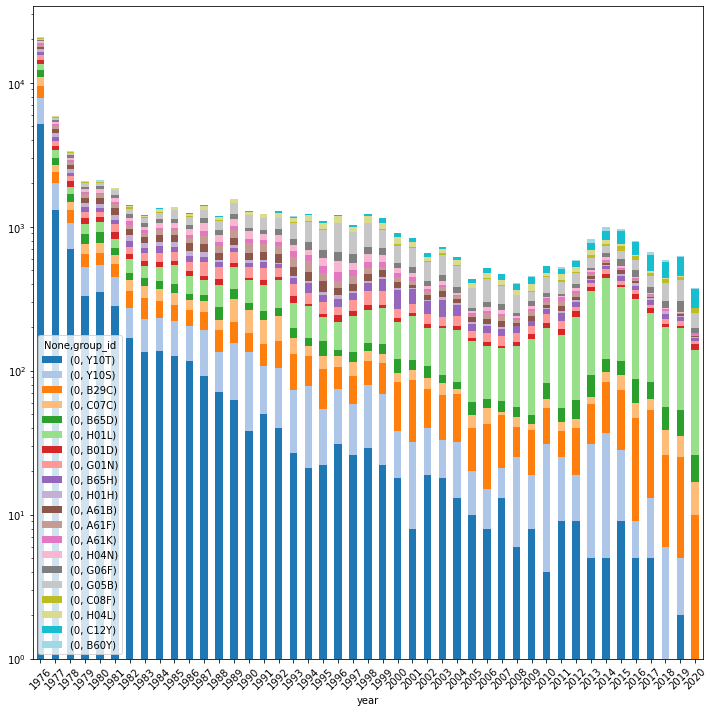

In [79]:
fig, ax = plt.subplots(figsize=(12, 12))

cmap = cm.get_cmap('tab20', len(CPCFULL_code_appearance_stacked_top.columns))
colors = cmap(range(len(CPCFULL_code_appearance_stacked_top.columns)))

CPCFULL_code_appearance_stacked_top.plot(ax=ax, kind='bar', stacked=True, color=colors, rot=45)
plt.yscale('log')

In [81]:
CPCFULL_code_appearance_stacked_top.sum().sum()

72117.0

## The distribution of CPC codes per inventor

In [15]:
CPCFULL_inventor = ddf[['number', 'inventor_id']].merge(ddf_cpc_full, how='left',
                                    left_on='number', right_index=True).\
                    map_partitions(lambda x: x[['inventor_id', 'subgroup_id']].drop_duplicates().\
                    groupby('inventor_id').nunique()).compute()
CPCFULL_inventor

<AxesSubplot:ylabel='Count'>

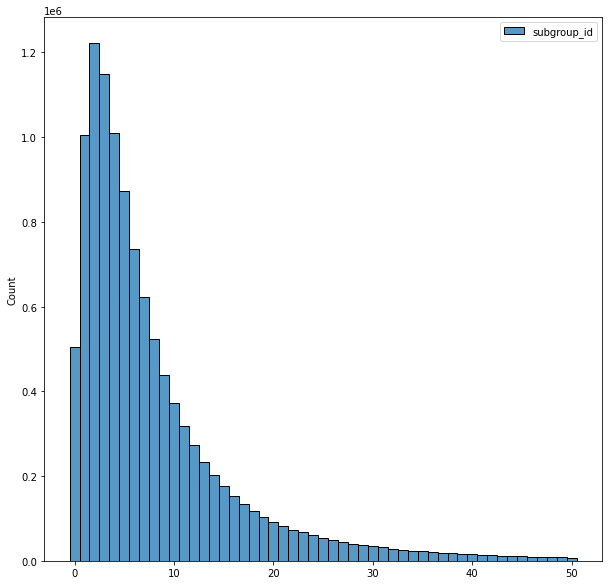

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.histplot(CPCFULL_inventor, bins=51, binrange=(0,50), discrete=True)
